In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
import pytz

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
data2019 = pd.read_csv('./piracy2019.csv', parse_dates = ['Date'])
data2020 = pd.read_csv('./piracy2020.csv', parse_dates = ['Date'])
data2021 = pd.read_csv('./piracy2021.csv', parse_dates = ['Date'])
data = pd.concat([data2019, data2020, data2021], axis = 0).reset_index(drop = True)
data['Vessel'] = data['Vessel'].fillna('Unknown')
data = data.dropna()
print(data.shape)
data.head()

(362, 8)


,lat,lon,AttackID,Vessel,Status,Location,Narration,Date
0,1.166667,103.933334,162-19,Tug,Attempted,Singapore Straits.,Five to seven persons in a wooden boat approac...,2019-12-03 02:10:00+07:00
1,3.966667,9.083333,161-19,Product Tanker,Boarded,"Limboh Anchorage, Cameroon.",Around six persons armed with guns boarded an ...,2019-12-30 23:30:00+01:00
2,1.270000,104.223335,160-19,Bulk Carrier,Boarded,Singapore Straits.,Chief Engineer onboard a bulk carrier underway...,2019-11-28 22:20:00+07:00
3,36.763992,3.063190,159-19,LPG Tanker,Attempted,Algeria.,Duty crew onboard a berthed tanker noticed thr...,2019-12-13 05:30:00+01:00
4,1.150000,103.483330,158-19,Product Tanker,Boarded,Singapore Straits.,Five robbers boarded a product tanker underway...,2019-12-24 23:20:00+07:00


In [3]:
p_vessels = {
    'General Cargo': 20 / 100,
    'Specialized Cargo': 0.3 / 100,
    'Container': 6 / 100,
    'RoRo Cargo': 1.8 / 100,
    'Dry Bulk Carrier': 12.7 / 100,
    'Liquid Bulk Tanker': 14.7 / 100,
    'LNG Tanker': 2 / 100,
    'LPG Tanker': 0.9 / 100,
    'Passenger Ship': 8 / 100,
    'Offshore Vessel': 9 / 100,
    'Service Vessel': 4 / 100,
    'Tug': 20 / 100,
    'Other': 0.6 / 100
}

p_vessels = {
    'Tug': p_vessels['Tug'],
    'Product Tanker': p_vessels['LPG Tanker'],
    'Bulk Carrier': p_vessels['Dry Bulk Carrier'],
    'LPG Tanker': p_vessels['LPG Tanker'],
    'Crude Oil Tanker': p_vessels['LPG Tanker'],
    'Offshore Tug': p_vessels['Tug'],
    'Vehicle Carrier': p_vessels['RoRo Cargo'],
    'Passenger Boat': p_vessels['Passenger Ship'],
    'Container': p_vessels['Container'],
    'Fishing Vessel': p_vessels['Other'],
    'Research Vessel': p_vessels['Service Vessel'],
    'General Cargo': p_vessels['General Cargo'],
    'Chemical Tanker': p_vessels['Liquid Bulk Tanker'],
    'LNG Tanker': p_vessels['LNG Tanker'],
    'Offshore Supply Ship': p_vessels['Offshore Vessel'],
    'Maintenance Pontoon': p_vessels['Service Vessel'],
    'Tanker': p_vessels['LNG Tanker'] + p_vessels['LPG Tanker'] + p_vessels['Liquid Bulk Tanker'],
    'Yacht': p_vessels['Passenger Ship'],
    'Heavy Load Carrier': p_vessels['Dry Bulk Carrier'],
    'Pleasure Craft': p_vessels['Passenger Ship'],
    'Offshore Support Vessel': p_vessels['Offshore Vessel'],
    'Landing Craft': p_vessels['Other'],
    'Ore Carrier': p_vessels['Dry Bulk Carrier'],
    'Other': p_vessels['Other']
}

def find_vessel_bayes(data, col):
    col_data = data[data[col] != 'Unknown'][col]
    vessel_bayes = {}
    vessel_types = col_data.unique()
    for vessel_type in vessel_types:
        p_vessel_given_pirated = col_data[col_data == vessel_type].shape[0] / data.shape[0]
        p_vessel = p_vessels[vessel_type]
        vessel_bayes[vessel_type] = p_vessel_given_pirated / p_vessel
    return vessel_bayes

In [4]:
data['Hour'] = data['Date'].apply(lambda x: x.hour)
data['Month'] = data['Date'].apply(lambda x: x.month)

In [5]:
def find_bayes(data, col):
    col_bayes = {}
    col_types = data[col].unique()
    for col_type in col_types:
        p_col_given_pirated = data[data[col] == col_type].shape[0] / data.shape[0]
        p_col = 1 / len(col_types)
        col_bayes[col_type] = p_col_given_pirated / p_col
    return col_bayes

In [6]:
X = np.asarray(list(zip(data['lon'].values, data['lat'].values)))

In [7]:
"""
range_n_clusters = np.arange(2, 10)
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
"""

'\nrange_n_clusters = np.arange(2, 10)\nfor n_clusters in range_n_clusters:\n\n    # Initialize the clusterer with n_clusters value and a random generator\n    # seed of 10 for reproducibility.\n    clusterer = KMeans(n_clusters=n_clusters, random_state=10)\n    cluster_labels = clusterer.fit_predict(X)\n\n    # The silhouette_score gives the average value for all the samples.\n    # This gives a perspective into the density and separation of the formed\n    # clusters\n    silhouette_avg = silhouette_score(X, cluster_labels)\n    print("For n_clusters =", n_clusters,\n          "The average silhouette_score is :", silhouette_avg)\n'

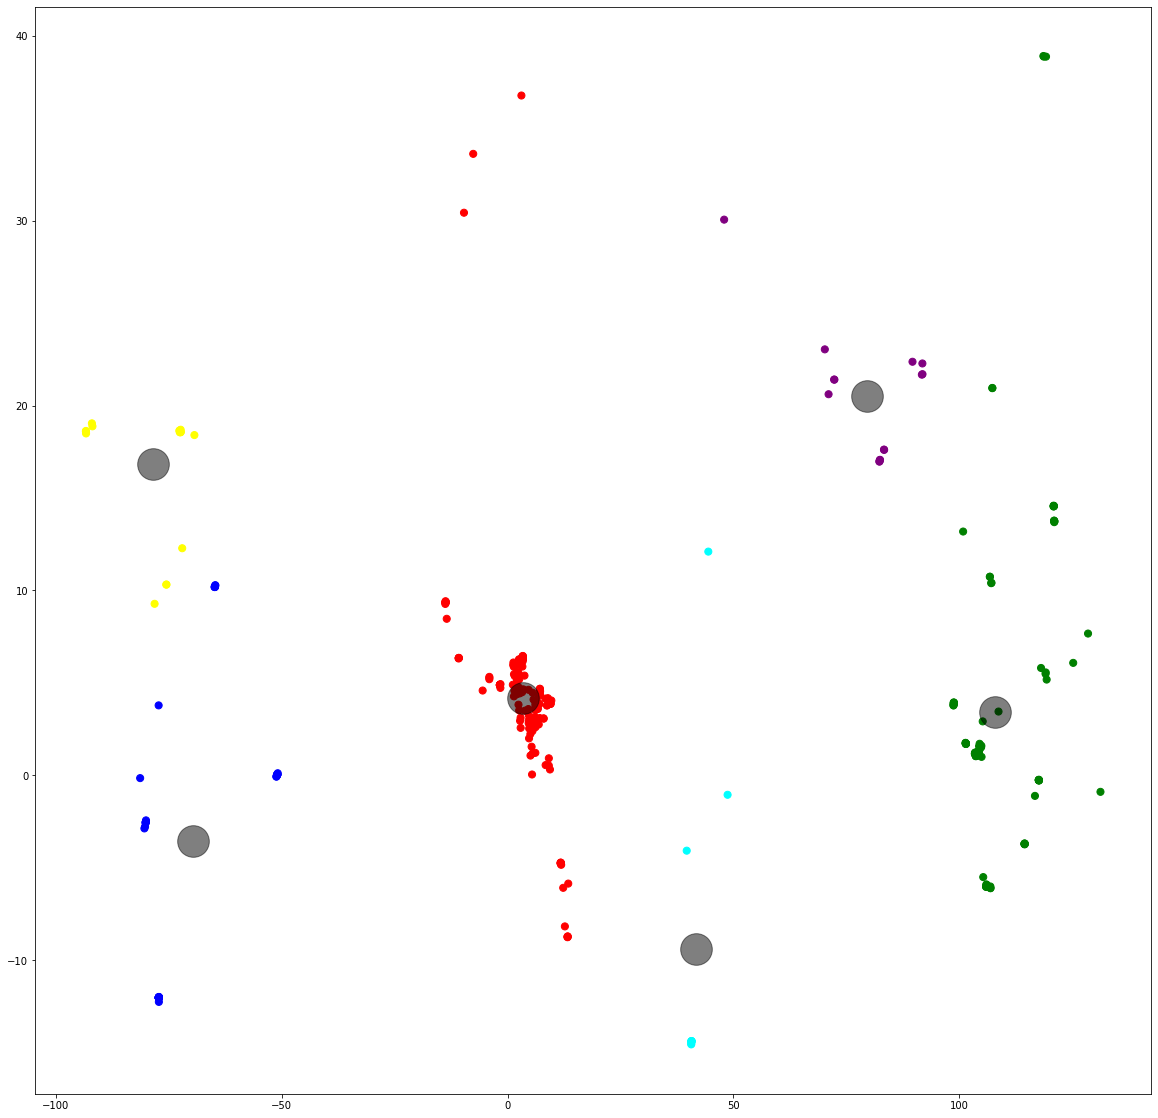

In [8]:
n_clusters = 6

clusterer = KMeans(n_clusters = n_clusters, random_state = 10)
cluster_labels = clusterer.fit_predict(X)
data = data.assign(ClusterLabel = cluster_labels)
centroids = clusterer.cluster_centers_
data = data.assign(ClusterLat = data['ClusterLabel'].apply(lambda x: centroids[x][1]))
data = data.assign(ClusterLon = data['ClusterLabel'].apply(lambda x: centroids[x][0]))
data = data.assign(ClusterLatDiff = (data['ClusterLat'] - data['lat']).abs())
data = data.assign(ClusterLonDiff = (data['ClusterLon'] - data['lon']).abs())
data = data.assign(ClusterDist = np.sqrt(data['ClusterLatDiff'] ** 2 + data['ClusterLonDiff'] ** 2))
data = data.drop(['ClusterLatDiff', 'ClusterLonDiff', 'ClusterLat', 'ClusterLon'], axis = 1)

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
color_map = {0: 'red', 1: 'green', 2:'blue', 3: 'cyan', 4: 'purple', 5: 'yellow'}
ax.scatter(data['lon'], data['lat'], c = [color_map[x] for x in cluster_labels], s = 50)
ax.scatter([x[0] for x in centroids], [x[1] for x in centroids], c = 'black', s = 1000, alpha = 0.5)
plt.show()

In [9]:
today_date = datetime.utcnow().astimezone(pytz.utc)
data['DaysElapsed'] = data['Date'].apply(lambda x: (today_date - x.astimezone(pytz.utc)).days)

In [10]:
cluster_count = data.groupby('ClusterLabel')['DaysElapsed'].aggregate('count')
data = data.merge(cluster_count, on = 'ClusterLabel')
data = data.rename({'DaysElapsed_x': 'DaysElapsed', 'DaysElapsed_y': 'ClusterCount'}, axis = 1)

In [11]:
cluster_min = data.groupby('ClusterLabel')['DaysElapsed'].aggregate('min')
data = data.merge(cluster_min, on = 'ClusterLabel')
data = data.rename({'DaysElapsed_x': 'DaysElapsed', 'DaysElapsed_y': 'ClusterLatestAttack'}, axis = 1)

In [12]:
cluster_radius = data.groupby('ClusterLabel')['ClusterDist'].aggregate('max')
data = data.merge(cluster_radius, on = 'ClusterLabel')
data = data.rename({'ClusterDist_x': 'ClusterDist', 'ClusterDist_y': 'ClusterRadius'}, axis = 1)
data['ClusterDistPerc'] = data['ClusterDist'] / data['ClusterRadius']

In [13]:
data['ClusterLabel'] = data.apply(lambda x: x['ClusterLabel'] if x['ClusterDistPerc'] <= 0.8 else -1, axis = 1)
total_area = 180 * 360
cluster_area = data.groupby('ClusterLabel')['ClusterRadius'].aggregate('mean')
cluster_area = cluster_area[cluster_area.index != -1]
safe_area = total_area - (np.pi * cluster_area ** 2).sum()
data['ClusterAreaPerc'] = data.apply(lambda x: (np.pi * x['ClusterRadius'] ** 2) / total_area if x['ClusterLabel'] != -1 else safe_area / total_area, axis = 1)

area_prob = data.groupby('ClusterLabel')['ClusterAreaPerc'].aggregate('mean')

In [14]:
def find_cluster_bayes(data, col):
    cluster_bayes = {}
    cluster_types = data[col].unique()
    for cluster_type in cluster_types:
        p_cluster_given_pirated = data[data[col] == cluster_type].shape[0] / data.shape[0]
        p_cluster = area_prob.loc[cluster_type]
        cluster_bayes[cluster_type] = p_cluster_given_pirated / p_cluster
    return cluster_bayes

In [15]:
earliest_attack = (today_date - data['Date'].min().astimezone(pytz.utc)).days
data['ClusterLatestAttack'] = data.apply(lambda x: x['ClusterLatestAttack'] if x['ClusterLabel'] != -1 else earliest_attack, axis = 1)
def categorize_ClusterLatestAttack(x):
    if(x <= 7):
        return 3
    elif(x <= 30):
        return 2
    else:
        return 1
data['LatestAttackWeight'] = data['ClusterLatestAttack'].apply(categorize_ClusterLatestAttack)

In [16]:
def find_weighted_cluster_bayes(data, col):
    cluster_bayes = {}
    cluster_types = data[col].unique()
    for cluster_type in cluster_types:
        p_cluster_given_pirated = data[data[col] == cluster_type]['LatestAttackWeight'].sum() / data['LatestAttackWeight'].sum()
        p_cluster = area_prob.loc[cluster_type]
        cluster_bayes[cluster_type] = p_cluster_given_pirated / p_cluster
    return cluster_bayes

In [17]:
vessel_bayes = find_vessel_bayes(data, 'Vessel')
hour_bayes = find_bayes(data, 'Hour')
month_bayes = find_bayes(data, 'Month')
cluster_bayes = find_cluster_bayes(data, 'ClusterLabel')
weighted_cluster_bayes = find_weighted_cluster_bayes(data, 'ClusterLabel')

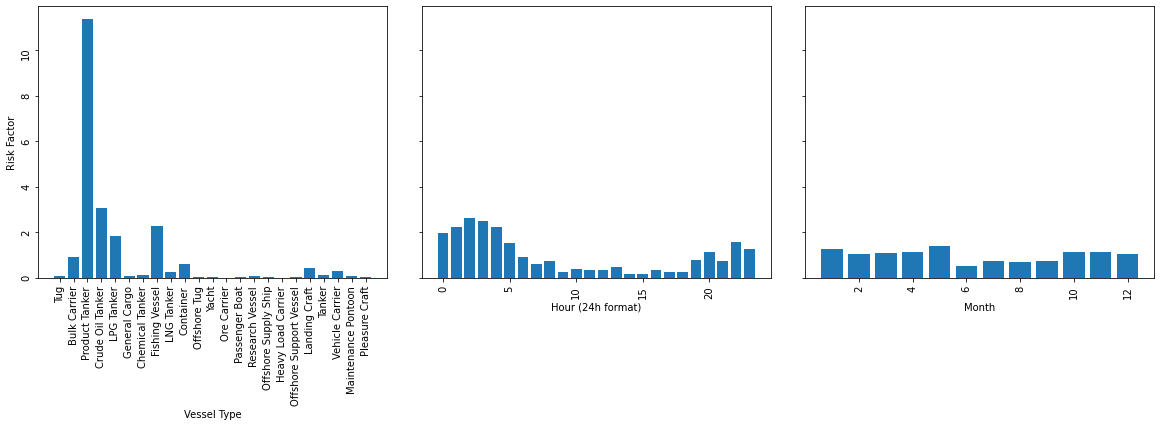

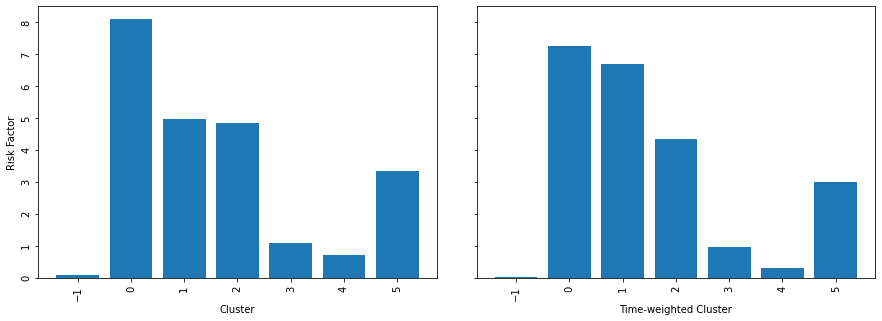

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5), sharey = True)
ax[0].bar(vessel_bayes.keys(), vessel_bayes.values())
ax[0].tick_params(rotation = 90)
ax[0].set_ylabel("Risk Factor")
ax[0].set_xlabel("Vessel Type")
ax[1].bar(hour_bayes.keys(), hour_bayes.values())
ax[1].tick_params(rotation = 90)
ax[1].set_xlabel("Hour (24h format)")
ax[2].bar(month_bayes.keys(), month_bayes.values())
ax[2].tick_params(rotation = 90)
ax[2].set_xlabel("Month")
plt.subplots_adjust(wspace = 0.1)
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = True)
ax[0].bar(cluster_bayes.keys(), cluster_bayes.values())
ax[0].tick_params(rotation = 90)
ax[0].set_ylabel("Risk Factor")
ax[0].set_xlabel("Cluster")
ax[1].bar(weighted_cluster_bayes.keys(), weighted_cluster_bayes.values())
ax[1].tick_params(rotation = 90)
ax[1].set_xlabel("Time-weighted Cluster")
plt.subplots_adjust(wspace = 0.1)
plt.show()

In [19]:
def get_risk_score(sample_input):
    sample_cluster = clusterer.predict([[sample_input['Lon'], sample_input['Lat']]])[0]
    sample_cluster_centroid = centroids[sample_cluster]

    def find_cluster_dist_perc(x1, y1, x2, y2, cluster_label):
        sample_cluster_dist = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        sample_cluster_radius = cluster_radius.loc[cluster_label]
        return sample_cluster_dist / sample_cluster_radius

    sample_cluster_dist_perc = find_cluster_dist_perc(sample_input['Lon'], sample_input['Lat'], sample_cluster_centroid[0], sample_cluster_centroid[1], sample_cluster)
    if(sample_cluster_dist_perc > 0.8):
        sample_cluster = -1

    sample_vessel_bayes = vessel_bayes[sample_input['Vessel']]
    sample_hour_bayes = hour_bayes[sample_input['Hour']]
    sample_month_bayes = month_bayes[sample_input['Month']]
    sample_weighted_cluster_bayes = weighted_cluster_bayes[sample_cluster]

    final_score = sample_vessel_bayes * sample_hour_bayes * sample_month_bayes * sample_weighted_cluster_bayes
    
    return final_score, sample_vessel_bayes, sample_hour_bayes, sample_month_bayes, sample_weighted_cluster_bayes

# Global Risk Map

### Inputs: Vessel Type, Hour & Month
### Outputs: Risk Map

In [20]:
sample_input = {
    'Vessel': 'Product Tanker',
    'Hour': 3,
    'Month': 5
}

from tqdm.notebook import tqdm

earth_grid = np.zeros((180, 360))

lat_range = np.arange(-90, 90)
lon_range = np.arange(-180, 180)
for lat_idx, lat in tqdm(enumerate(lat_range), total = len(lat_range)):
    for lon_idx, lon in enumerate(lon_range):
        sample_input['Lat'] = lat
        sample_input['Lon'] = lon
        sample_score = get_risk_score(sample_input)[0]
        earth_grid[lat_idx, lon_idx] = sample_score

earth_grid_df = pd.DataFrame(earth_grid[::-1, :], columns = lon_range, index = lat_range[::-1])

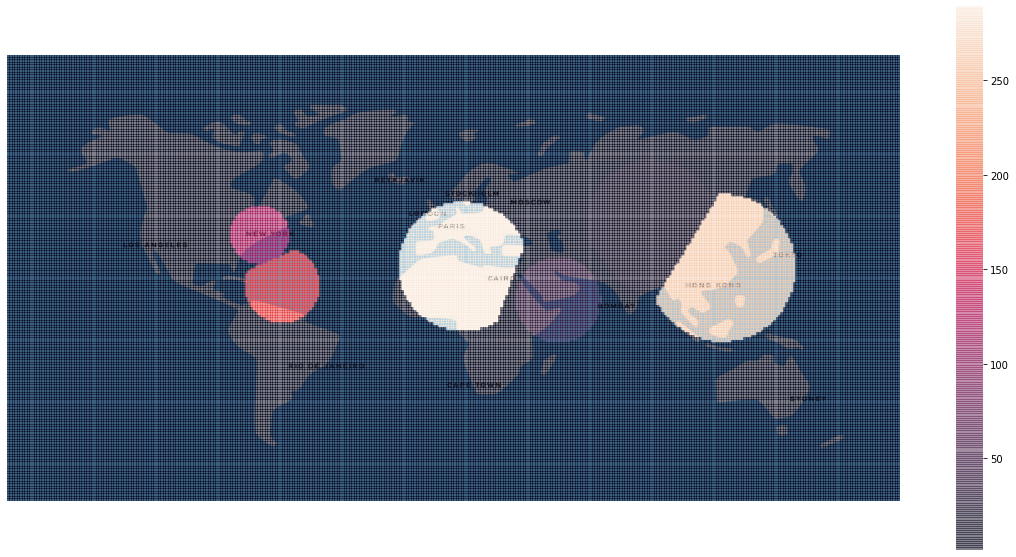

In [21]:
img = plt.imread('./world_map.jpeg')
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.imshow(img[::-1, :, :], extent = [0, 360, 0, 180])
sns.heatmap(earth_grid_df, ax = ax, alpha = 0.5)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Journey Risk Analyzer

### Inputs: Vessel Type, Month, Journey coordinates, Approx. Journey Time (in hours), Journey Start Hour
### Outputs: Risk Time Series along the journey coordinates

In [22]:
sample_input = {
    'Vessel': 'Product Tanker',
    'Month': 5
}

journey = [
          [
            75.41015624999999,
            12.211180191503997
          ],
          [
            46.05468749999999,
            -37.020098201368114
          ],
          [
            9.31640625,
            -38.685509760012
          ],
          [
            -1.23046875,
            5.441022303717974
          ]
        ]
journey_time = 24
start_time = 17

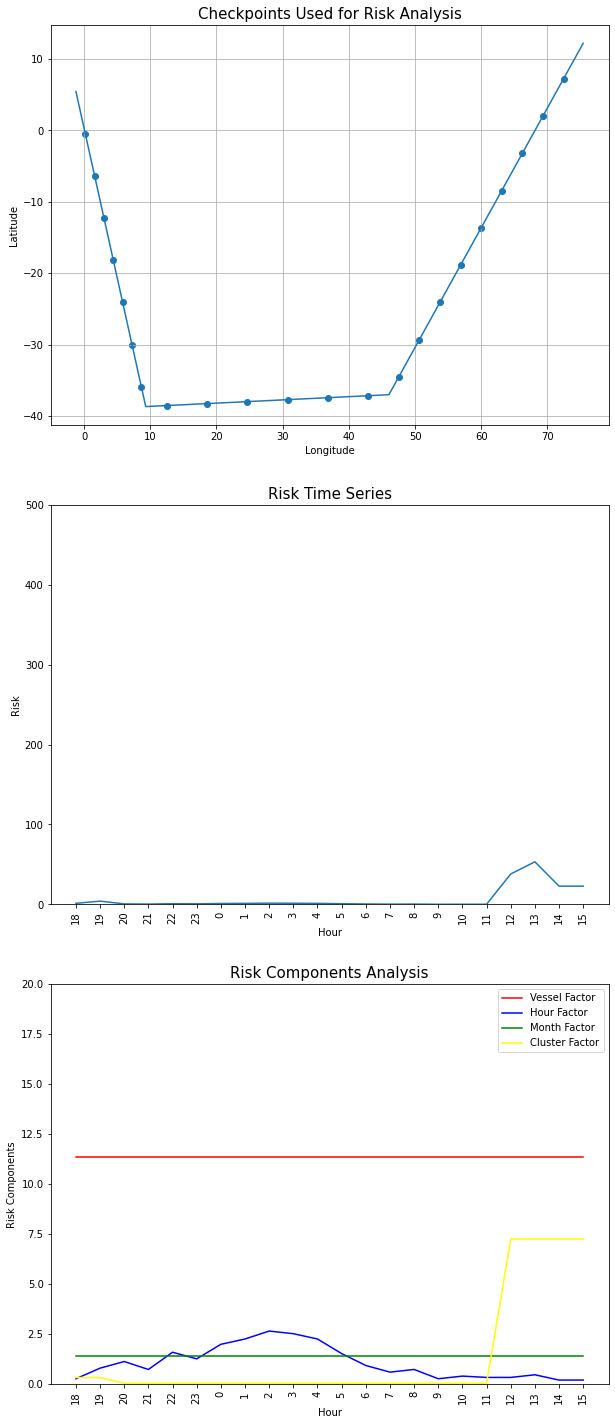

In [23]:
def find_line_dist(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

total_dist = np.sum([find_line_dist(journey[x], journey[x + 1]) for x in range(len(journey) - 1)])

timepoints = [x % 24 for x in np.arange(start_time + 1, start_time + journey_time - 1)]
linepoints = np.linspace(total_dist / journey_time, total_dist, num = journey_time - 1)
line_diff = linepoints[0]

risk_scores = {}
finished_line_dist = 0
line_idx = 0
line_length = find_line_dist(journey[line_idx], journey[line_idx + 1])
for checkpoint_num in range(journey_time - 2):
    if(linepoints[checkpoint_num] - finished_line_dist > line_length):
        finished_line_dist += line_length
        line_idx += 1
        line_length = find_line_dist(journey[line_idx], journey[line_idx + 1])
    lon = journey[line_idx][0] + (journey[line_idx + 1][0] - journey[line_idx][0]) * (linepoints[checkpoint_num] - finished_line_dist) / line_length
    lat = journey[line_idx][1] + (journey[line_idx + 1][1] - journey[line_idx][1]) * (linepoints[checkpoint_num] - finished_line_dist) / line_length
    sample_input['Hour'] = timepoints[checkpoint_num]
    sample_input['Lat'] = lat
    sample_input['Lon'] = lon
    risk_score, c1, c2, c3, c4 = get_risk_score(sample_input)
    risk_scores[checkpoint_num] = {}
    risk_scores[checkpoint_num]['hour'] = timepoints[checkpoint_num]
    risk_scores[checkpoint_num]['lat'] = lat
    risk_scores[checkpoint_num]['lon'] = lon
    risk_scores[checkpoint_num]['risk'] = risk_score
    risk_scores[checkpoint_num]['remaining'] = finished_line_dist
    risk_scores[checkpoint_num]['c1'] = c1
    risk_scores[checkpoint_num]['c2'] = c2
    risk_scores[checkpoint_num]['c3'] = c3
    risk_scores[checkpoint_num]['c4'] = c4

risk_scores = pd.DataFrame.from_dict(risk_scores).transpose()

fig, ax = plt.subplots(3, 1, figsize = (10, 25))
ax[0].scatter(risk_scores['lon'], risk_scores['lat'])
ax[0].plot([x[0] for x in journey], [x[1] for x in journey])
ax[0].grid('on')
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].set_title("Checkpoints Used for Risk Analysis", fontsize = 15)
ax[1].plot(risk_scores['risk'])
ax[1].set_xticks(np.arange(journey_time - 2))
ax[1].set_xticklabels(risk_scores['hour'].astype(int), rotation = 90)
ax[1].set_xlabel("Hour")
ax[1].set_ylabel("Risk")
ax[1].set_ylim(0, 500)
ax[1].set_title("Risk Time Series", fontsize = 15)
ax[2].plot(risk_scores['c1'], color = 'red', label = 'Vessel Factor')
ax[2].plot(risk_scores['c2'], color = 'blue', label = 'Hour Factor')
ax[2].plot(risk_scores['c3'], color = 'green', label = 'Month Factor')
ax[2].plot(risk_scores['c4'], color = 'yellow', label = 'Cluster Factor')
ax[2].set_xticks(np.arange(journey_time - 2))
ax[2].set_xticklabels(risk_scores['hour'].astype(int), rotation = 90)
ax[2].set_xlabel("Hour")
ax[2].set_ylabel("Risk Components")
ax[2].set_ylim(0, 20)
ax[2].legend(loc = 'best')
ax[2].set_title("Risk Components Analysis", fontsize = 15)
plt.show()